In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Data/DATA/RSCCASN.csv',parse_dates=True,index_col='DATE')

In [ ]:
df

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [ ]:
df.columns=['Sales']

<Axes: xlabel='DATE'>

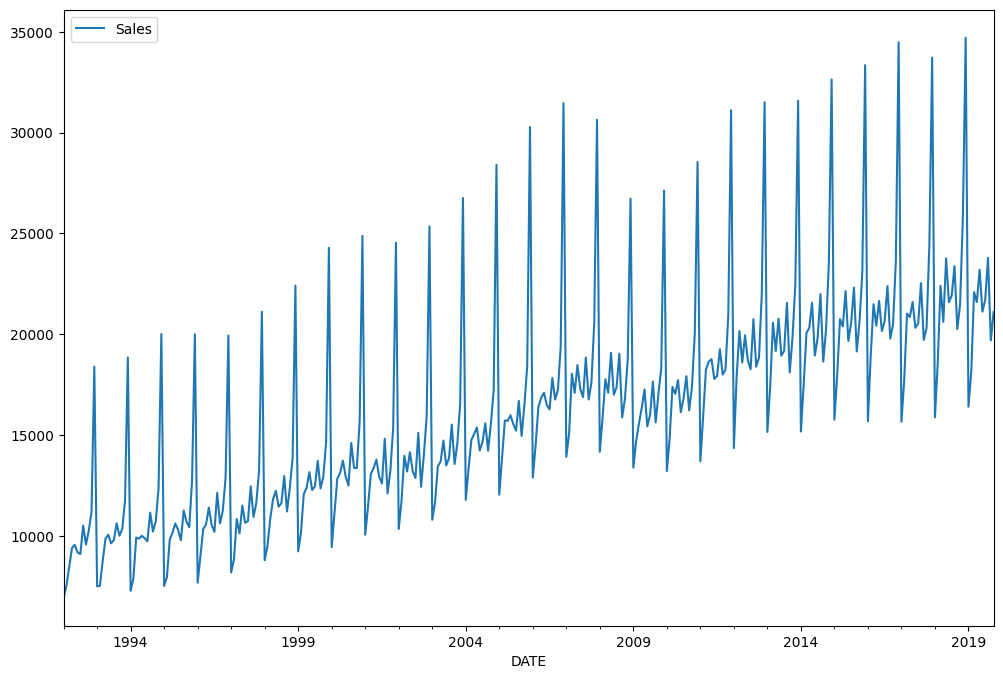

In [ ]:
df.plot(figsize=(12,8))

In [ ]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [ ]:
test_size= 18
test_ind = len(df) - test_size

In [ ]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [ ]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [ ]:
test

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler=MinMaxScaler()

In [ ]:
scaler.fit(train)

MinMaxScaler()

In [ ]:
scaled_train = scaler.transform(train)

In [ ]:
scaled_test = scaler.transform(test)

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
length=12

In [ ]:
generator = TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=1)

In [ ]:
from tensorflow.keras.models import Sequential

In [ ]:
from tensorflow.keras.layers import Dense,LSTM

In [ ]:
n_features = 1

In [ ]:
model = Sequential()

In [ ]:
model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test,length=length,batch_size=1)

In [ ]:
model.fit_generator(generator,epochs=20,validation_data=validation_generator,callbacks=[early_stop])

Epoch 1/20


<ipython-input-41-95afb4e45afd>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20,validation_data=validation_generator,callbacks=[early_stop])


304/304 [==============================] - 5s 9ms/step - loss: 0.0245 - val_loss: 0.0083
Epoch 2/20
304/304 [==============================] - 3s 9ms/step - loss: 0.0179 - val_loss: 0.0037
Epoch 3/20
304/304 [==============================] - 4s 12ms/step - loss: 0.0097 - val_loss: 5.5290e-04
Epoch 4/20
304/304 [==============================] - 2s 8ms/step - loss: 0.0052 - val_loss: 0.0097
Epoch 5/20
304/304 [==============================] - 2s 8ms/step - loss: 0.0043 - val_loss: 8.9659e-04


In [ ]:
losses = pd.DataFrame(model.history.history)

<Axes: >

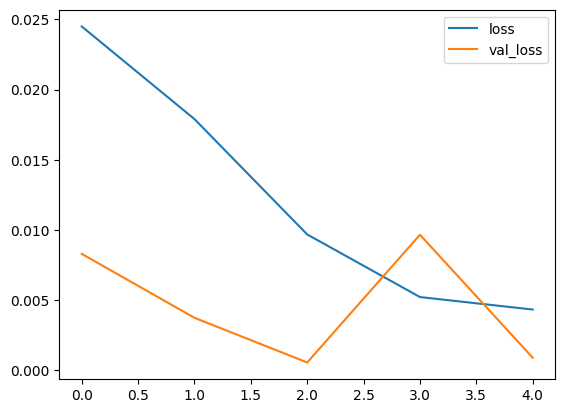

In [ ]:
losses.plot()

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]

    # store prediction
    test_predictions.append(current_pred)

    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 26ms/step


In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
test['predictions'] = true_predictions

<ipython-input-46-fa6c3af7c69f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = true_predictions


In [ ]:
test

,Sales,predictions
DATE,,
2018-05-01,23764,21706.867520
2018-06-01,21589,20829.867476
2018-07-01,21919,21038.607822
2018-08-01,23381,22539.510755
2018-09-01,20260,20455.149454
2018-10-01,21473,20956.562991
2018-11-01,25831,24446.067211
2018-12-01,34706,34416.221631
2019-01-01,16410,17448.268938


<Axes: xlabel='DATE'>

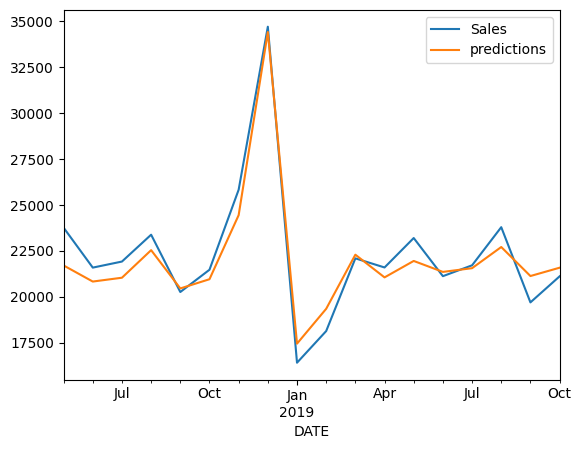

In [ ]:
test.plot()

In [ ]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [ ]:
length=12
gnerator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [ ]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(generator,epochs=8)

Epoch 1/8


<ipython-input-51-74a9761509e5>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=8)


304/304 [==============================] - 5s 8ms/step - loss: 0.0237
Epoch 2/8
304/304 [==============================] - 3s 8ms/step - loss: 0.0161
Epoch 3/8
304/304 [==============================] - 3s 11ms/step - loss: 0.0062
Epoch 4/8
304/304 [==============================] - 4s 12ms/step - loss: 0.0036
Epoch 5/8
304/304 [==============================] - 3s 9ms/step - loss: 0.0020
Epoch 6/8
304/304 [==============================] - 3s 10ms/step - loss: 0.0014
Epoch 7/8
304/304 [==============================] - 4s 12ms/step - loss: 0.0020
Epoch 8/8
304/304 [==============================] - 3s 8ms/step - loss: 0.0017


In [ ]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]

    # store prediction
    forecast.append(current_pred)

    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 91ms/step


In [ ]:
forecast = scaler.inverse_transform(forecast)

In [ ]:
forecast

array([[26270.06660938],
       [36711.54949188],
       [16832.47711778],
       [18339.24356174],
       [21877.31896544],
       [21465.00157738],
       [23106.00655842],
       [21218.09053564],
       [21743.24049902],
       [23880.95704412],
       [20288.57828546],
       [21632.07430029]])

In [ ]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [ ]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [ ]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [ ]:
forecast_df

,Forecast
2019-11-01,26270.066609
2019-12-01,36711.549492
2020-01-01,16832.477118
2020-02-01,18339.243562
2020-03-01,21877.318965
2020-04-01,21465.001577
2020-05-01,23106.006558
2020-06-01,21218.090536
2020-07-01,21743.240499
2020-08-01,23880.957044


<Axes: >

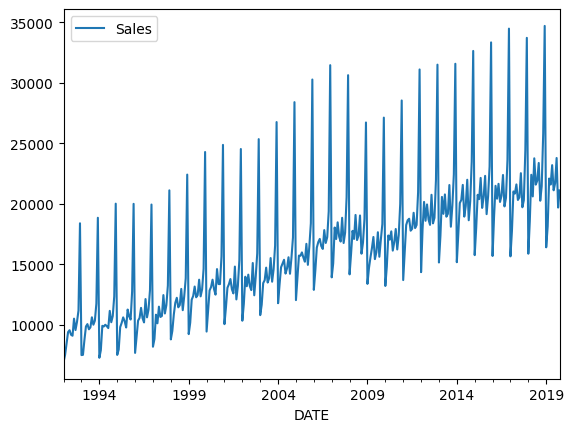

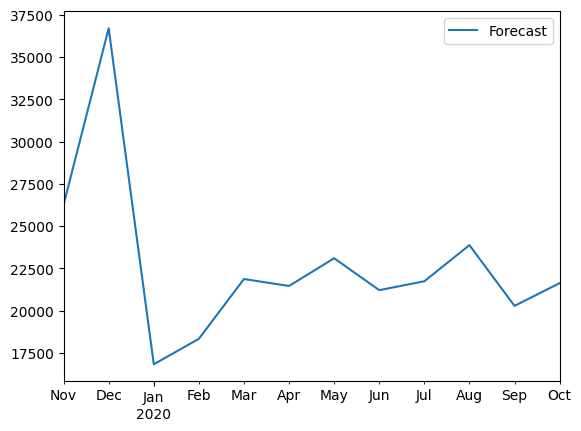

In [ ]:
df.plot()
forecast_df.plot()

<Axes: xlabel='DATE'>

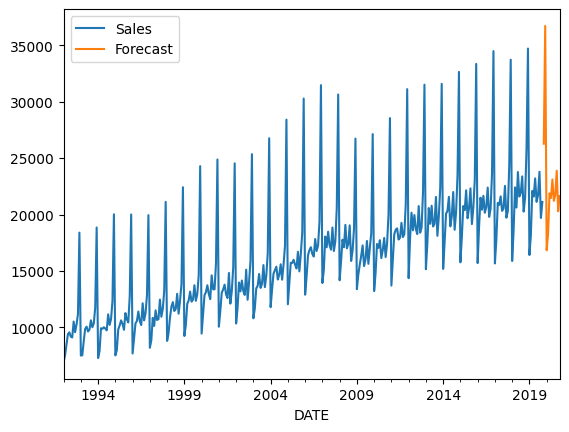

In [ ]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576.0, 611.0)

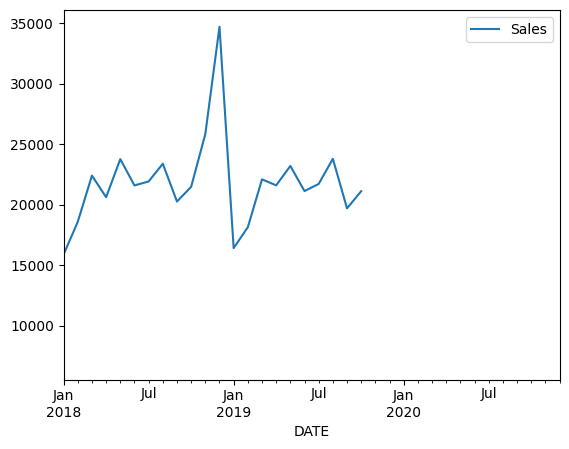

In [ ]:
x = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')